In [1]:
# Import libries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import lightgbm as lgb
import seaborn as sns
import warnings
from scipy import stats
from matplotlib.gridspec import GridSpec
from collections import Counter
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler




In [2]:
# Import dataframes AND Specify a custom delimiter for the CSV input (sep=' ')

red_df=pd.read_csv(r'C:\Users\jspad\Documents\Code Academy\Data Bases\winequality-red.csv', sep=';')
white_df=pd.read_csv(r'C:\Users\jspad\Documents\Code Academy\Data Bases\winequality-white.csv',sep=';')

#creating new column
red_df['quality_label']= red_df['quality'].apply(lambda value: 'low' 
if value <= 5 else 'medium'
if value <=6 else 'high')

white_df['quality_label']= white_df['quality'].apply(lambda value: 'low' 
if value <= 5 else 'medium'
if value <=6 else 'high')

# transforming these labels into categrical data type
red_df['quality_label'] = pd.Categorical(red_df['quality_label'],
categories=['low', 'medium', 'high'])
white_df['quality_label'] = pd.Categorical(white_df['quality_label'],
categories=['low', 'medium', 'high'])

# Combine the two datasets into wines.
red_df['wine_type'] = 'red'
white_df['wine_type'] = 'white'
wines = pd.concat([red_df, white_df])

# Re-shuffle records just to randomize data points and Creat Index column
wines = wines.sample(frac=1, random_state=43).reset_index(drop=True)
wines['Id']=wines.index

wines


In [29]:
# Describe Labels

q_low=wines[wines['quality_label'] == 'low'].describe()
q_medium=wines[wines['quality_label'] == 'medium'].describe()
q_high=wines[wines['quality_label'] == 'high'].describe()

wines.describe()

comparative_labels= pd.concat([q_low.iloc[:, lambda df: [1, 3, 4, 5, 10]], q_medium.iloc[:, lambda df: [1, 3, 4, 5, 10]], q_high.iloc[:, lambda df: [1, 3, 4, 5, 10]]], axis='columns', keys=['Low', 'Medium', 'High'])

round(comparative_labels,2)



Low                                                        \
      volatile acidity residual sugar chlorides free sulfur dioxide  alcohol   
count          2384.00        2384.00   2384.00             2384.00  2384.00   
mean              0.40           5.65      0.06               29.48     9.87   
std               0.19           4.92      0.04               19.84     0.84   
min               0.10           0.60      0.01                2.00     8.00   
25%               0.26           1.80      0.04               14.00     9.30   
50%               0.34           2.90      0.05               26.00     9.60   
75%               0.50           8.52      0.08               42.00    10.40   
max               1.58          23.50      0.61              289.00    14.90   

                Medium                                                        \
      volatile acidity residual sugar chlorides free sulfur dioxide  alcohol   
count          2836.00        2836.00   2836.00             2836.00  2836.00   
mean              0.31           5.55      0.05               31.17    10.59   
std               0.15           4.89      0.03               16.84     1.13   
min               0.08           0.70      0.02                1.00     8.40   
25%               0.21           1.80      0.04               18.00     9.60   
50%               0.27           3.10      0.05               29.00    10.50   
75%               0.37           8.30      0.06               42.00    11.40   
max               1.04          65.80      0.42              112.00    14.00   

                  High                                                        
      volatile acidity residual sugar chlorides free sulfur dioxide  alcohol  
count          1277.00        1277.00   1277.00             1277.00  1277.00  
mean              0.29           4.83      0.04               31.06    11.43  
std               0.12           4.06      0.02               15.34     1.22  
min               0.08           0.80      0.01                3.00     8.50  
25%               0.20           1.80      0.03               20.00    10.70  
50%               0.27           2.90      0.04               31.00    11.50  
75%               0.34           6.50      0.05               40.00    12.40  
max               0.92          19.25      0.36              108.00    14.20

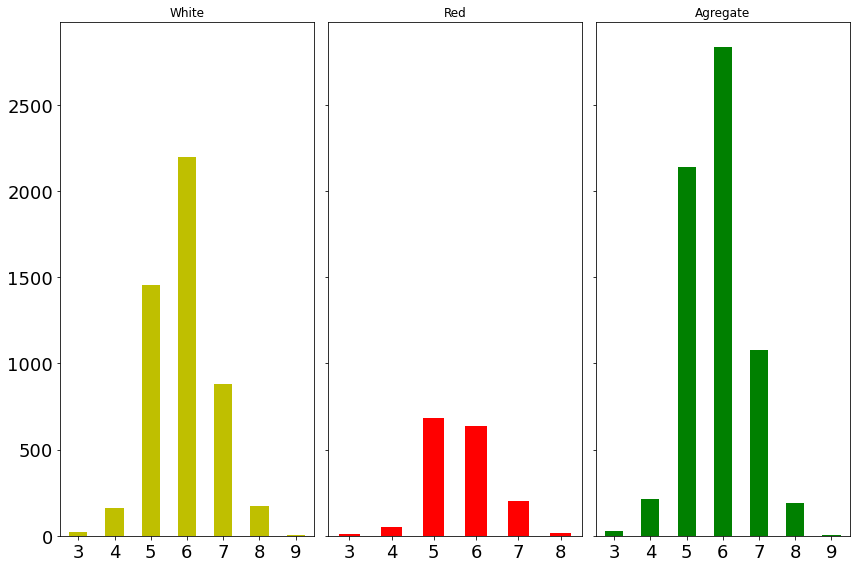

In [ ]:
# Vinho Verde Quality Class Distribution

quality_sort=pd.Categorical([3,4,5,6,7,8,9], ordered=True)

figure, axes = plt.subplots(1, 3, figsize=(12, 8), sharey=True)
plt.subplots_adjust(hspace=.0)
q=pd.DataFrame(data=(wines['quality'].value_counts().sort_index(level=quality_sort)))
qred=pd.DataFrame(data=(red_df['quality'].value_counts().sort_index(level=quality_sort)))
qwhite=pd.DataFrame(data=(white_df['quality'].value_counts().sort_index(level=quality_sort)))

qred.plot(ax=axes[1], kind='bar', rot=0, fontsize=18, legend=None, color='r'); axes[1].set_title('Red')
qwhite.plot(ax=axes[0], kind='bar', rot=0, fontsize=18, legend=None, color='y'); axes[0].set_title('White')
q.plot(ax=axes[2], y="quality", kind="bar", rot=0, fontsize=18, legend=None, color='g').set_title('Agregate');

#figure.suptitle('Vinho Verde Quality Class Distribution');
plt.tight_layout()

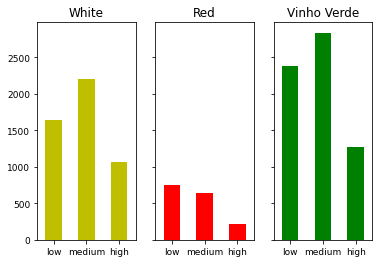

In [69]:
# Plot to show the distribution of qualities

label_sort=pd.Categorical(['low', 'medium', 'high'], ordered=True)

qred=pd.DataFrame(data=(red_df['quality_label'].value_counts().sort_index(level=label_sort)))
qwhite=pd.DataFrame(data=(white_df['quality_label'].value_counts().sort_index(level=label_sort)))
quality=pd.DataFrame(data=(wines['quality_label'].value_counts().sort_index(level=label_sort)))

figure, axes = plt.subplots(1, 3, sharey=True)
plt.subplots_adjust(hspace=.0)
qwhite.plot(ax=axes[0], kind='bar', rot=0, fontsize=9, legend=None, color='y'); axes[0].set_title('White')
qred.plot(ax=axes[1], kind='bar', rot=0, fontsize=9, legend=None, color='r'); axes[1].set_title('Red')
quality.plot(ax=axes[2], y="quality_label", kind="bar", rot=0, fontsize=9, legend=None, color='g').set_title('Vinho Verde');
#figure.suptitle('Horizontally stacked subplots');

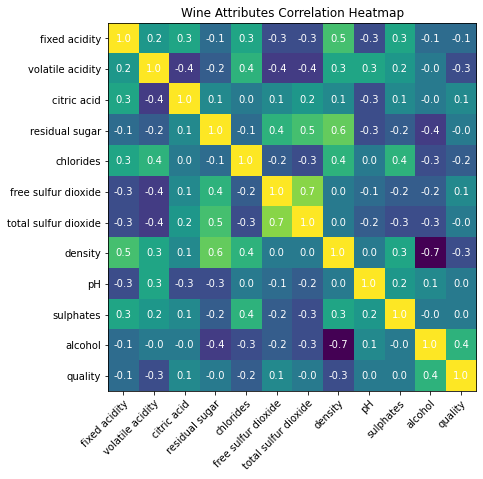

In [ ]:
# Wine Attributes Correlation Heatmap

wines_colums = ["fixed acidity", "volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
wines_corr = np.around(wines.corr(method='pearson', min_periods=1).to_numpy(), decimals=1)

fig, ax = plt.subplots()
im = ax.imshow(wines_corr)

# We want to show all ticks...
ax.set_xticks(np.arange(len(wines_colums)))
ax.set_yticks(np.arange(len(wines_colums)))
# # ... and label them with the respective list entries
ax.set_xticklabels(wines_colums)
ax.set_yticklabels(wines_colums)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(wines_colums)):
    for j in range(len(wines_colums)):
        text = ax.text(j, i, wines_corr[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Wine Attributes Correlation Heatmap")
fig.tight_layout()
fig.set_figheight(100)
plt.show()


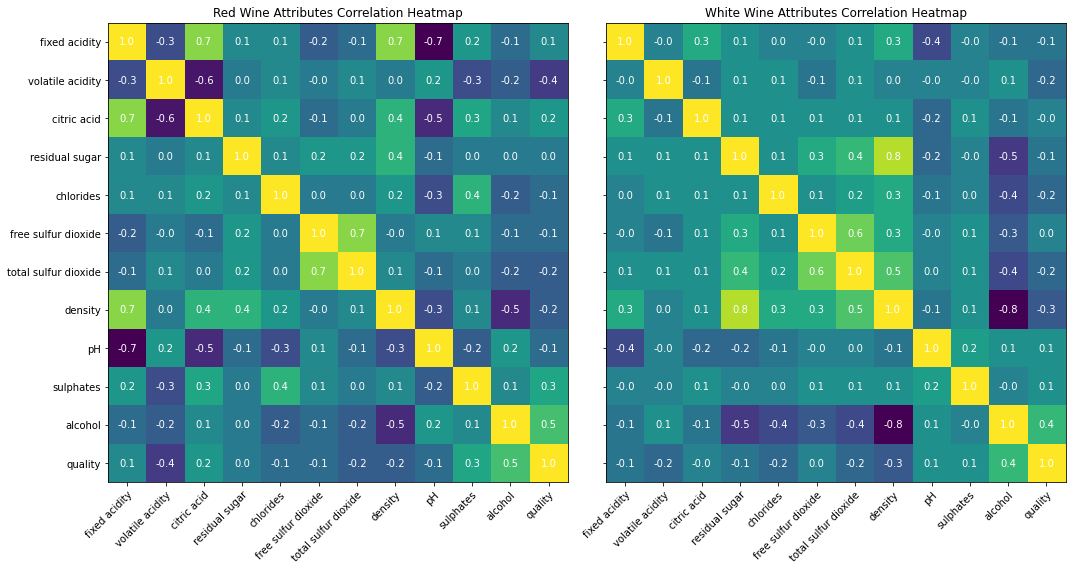

In [ ]:
# Comparative Attributes Correlation Heatmap - Red/White
 
wines_colums = ["fixed acidity", "volatile acidity","citric acid","residual sugar","chlorides","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]
red_corr = np.around(red_df.corr(method='pearson', min_periods=1).to_numpy(), decimals=1)
white_corr = np.around(white_df.corr(method='pearson', min_periods=1).to_numpy(), decimals=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

im1 = ax1.imshow(red_corr)
ax1.set_xticks(np.arange(len(wines_colums)))
ax1.set_yticks(np.arange(len(wines_colums)))
ax1.set_xticklabels(wines_colums)
ax1.set_yticklabels(wines_colums)
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(wines_colums)):
    for j in range(len(wines_colums)):
        text = ax1.text(j, i, red_corr[i, j],
                       ha="center", va="center", color="w")
ax1.set_title("Red Wine Attributes Correlation Heatmap")

im2 = ax2.imshow(white_corr)
ax2.set_xticks(np.arange(len(wines_colums)))
ax2.set_yticks(np.arange(len(wines_colums)))
ax2.set_xticklabels(wines_colums)
ax2.set_yticklabels(wines_colums)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(wines_colums)):
    for j in range(len(wines_colums)):
        text = ax2.text(j, i, white_corr[i, j],
                       ha="center", va="center", color="w")
ax2.set_title("White Wine Attributes Correlation Heatmap")



fig.tight_layout()
#fig.set_figheight(100)
plt.show()

In [ ]:
# Variables plot

tmp = wines.iloc[:, lambda df: [1, 3, 4, 5, 10, 12, 14]].drop('Id', axis=1)
g = sns.pairplot(tmp, hue='quality_label', markers='+')
plt.show()

In [ ]:
# ML Model Setup

# Relevant Variables: 

# A. According Data Exploring:
#    1. Residual Sugar
#    X. Density - Rindondante
#    2. Alcohol
#    3. Free SO2

# B. According Modeling and Futures importance:(tutte tranne le rindondanti - Empirio insegna?)
#    1. Volatile acidity
#    2. Chlorides
#    3. Free sulfur dioxide
#    4. Alcohol
#    5. Residual Sugar



# Models:
# X. Linear Regretion
# 2. KNN - Nearest Neighbor Algorithms
# 3. Random Forest
# 4. Lightgbm Booster
# 5. Xg Booster(?)
# 6. NAIVE BAYES


# Treat Data:
# 1. Split data --> Train vs Test
# 2. Scale data: Robust scaler (with outliers) 
# 3. Scale data: Standard scaler
# 4. Scale data: MinMax scaler

# ML Application
# 1. Red/White Predition --> R/W
# 2. Label Prediction
# 3. Label RED Pred
# 4. Label White Pred
# X. Class Prediction ---> Bad idea!!


In [38]:
# 1. Split Data

# from sklearn.model_selection import train_test_split
# from collections import Counter

X = wines.iloc[:, lambda df: [1, 3, 4, 5, 10]]
var_names = X.columns
y = np.array(wines['wine_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.wine_type)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))


Counter({'white': 4408, 'red': 1439}) Counter({'white': 490, 'red': 160})
Features: ['volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'alcohol']


In [62]:
# 2.1 Scale Data - Robust Scaler

from sklearn.preprocessing import RobustScaler

rs=RobustScaler()
X_train_rs = rs.fit_transform(X_train)
X_test_rs = rs.fit_transform(X_test)


In [42]:
# 2.2 Scale Data - Standard Scaler

from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_st = stdsc.fit_transform(X_train)
X_test_st = stdsc.transform(X_test)

In [58]:
# 2.3 Scale Data - MinMax Scaler 

from sklearn.preprocessing import MinMaxScaler

mms=MinMaxScaler()
X_train_mms = mms.fit_transform(X_train)
X_test_mms = mms.fit_transform(X_test)

In [57]:
# Model: KNN R/W

#from sklearn.neighbors import KNeighborsClassifier

X = wines.iloc[:, lambda df: [1, 3, 4, 5, 10]]
var_names = X.columns
y = np.array(wines['wine_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.wine_type)

stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree')
knn.fit(X_train, y_train)

pred_wines_rw_neigh= knn.predict(X_test)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

print(pred_wines_rw_neigh.shape)
print(y_test.shape)

print(metrics.classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,pred_wines_rw_neigh))

print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_rw_neigh)))
print('Training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(knn.score(X_test,y_test)))



Counter({'white': 4408, 'red': 1439}) Counter({'white': 490, 'red': 160})
Features: ['volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'alcohol']
(650,)
(650,)
              precision    recall  f1-score   support

         red       0.95      0.97      0.96       160
       white       0.99      0.98      0.99       490

    accuracy                           0.98       650
   macro avg       0.97      0.98      0.98       650
weighted avg       0.98      0.98      0.98       650

[[156   4]
 [  8 482]]
Cohen-Kappa score:  0.9506703769289148
Training accuracy: 0.9728
Testing accuracy: 0.9815


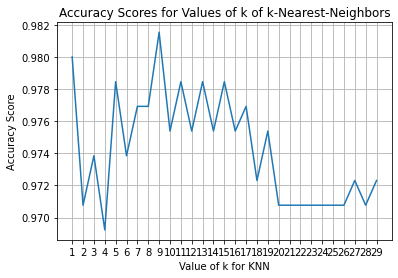

In [67]:
# experimenting with different n values
k_range = list(range(1,30))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(X_train_st, y_train)
    y_pred = knn.predict(X_test_st)
    scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(k_range, scores)
plt.grid()
plt.xticks(k_range)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

logreg = LogisticRegression()
logreg.fit(X_train_st, y_train)
y_pred = logreg.predict(X_test_st)
print(metrics.accuracy_score(y_test, y_pred))

In [68]:
# Model: KNN Label

X = wines.iloc[:, lambda df: [1, 3, 4, 5, 10]]
var_names = X.columns
y = np.array(wines['quality_label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.quality_label)


stdsc = StandardScaler()
X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=9, algorithm='kd_tree')
knn.fit(X_train, y_train)

pred_wines_label_neigh= knn.predict(X_test)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

print(pred_wines_label_neigh.shape)
print(y_test.shape)

print(metrics.classification_report(y_test,knn.predict(X_test)))
print(confusion_matrix(y_test,pred_wines_label_neigh))

print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_label_neigh)))
print('Training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(knn.score(X_test,y_test)))


Counter({'medium': 2552, 'low': 2146, 'high': 1149}) Counter({'medium': 284, 'low': 238, 'high': 128})
Features: ['volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'alcohol']
(650,)
(650,)
              precision    recall  f1-score   support

        high       0.56      0.52      0.54       128
         low       0.66      0.68      0.67       238
      medium       0.59      0.60      0.60       284

    accuracy                           0.61       650
   macro avg       0.60      0.60      0.60       650
weighted avg       0.61      0.61      0.61       650

[[ 66  13  49]
 [  9 162  67]
 [ 42  72 170]]
Cohen-Kappa score:  0.38769559723977054
Training accuracy: 0.6615
Testing accuracy: 0.6123


In [ ]:
# Model: Random Forest R/W

X = wines.iloc[:, lambda df: [1, 4, 5, 10]]
var_names = X.columns
y = np.array(wines['wine_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.wine_type)


rs=RobustScaler()

X_train = rs.fit_transform(X_train)
X_test = rs.fit_transform(X_test)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

pred_wines_rw_forest= clf.predict(X_test)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

print(pred_wines_rw_forest.shape)
print(y_test.shape)

print(metrics.classification_report(y_test,clf.predict(X_test)))
print(confusion_matrix(y_test,pred_wines_rw_forest))

print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_rw_forest)))
print('Training accuracy: {:.4f}'.format(clf.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(clf.score(X_test,y_test)))




Counter({'white': 4408, 'red': 1439}) Counter({'white': 490, 'red': 160})
Features: ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'alcohol']
(650,)
(650,)
              precision    recall  f1-score   support

         red       0.95      0.96      0.95       160
       white       0.99      0.98      0.98       490

    accuracy                           0.98       650
   macro avg       0.97      0.97      0.97       650
weighted avg       0.98      0.98      0.98       650

[[153   7]
 [  8 482]]
Cohen-Kappa score:  0.9379494685928849
Training accuracy: 0.9997
Testing accuracy: 0.9769


In [ ]:
# Model: Random Forest Label

X = wines.iloc[:, lambda df: [1, 4, 5, 10]]
var_names = X.columns
y = np.array(wines['quality_label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.quality_label)


rs=RobustScaler()

X_train = rs.fit_transform(X_train)
X_test = rs.fit_transform(X_test)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)


pred_wines_label_forest= clf.predict(X_test)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

print(pred_wines_label_forest.shape)
print(y_test.shape)

print(metrics.classification_report(y_test,clf.predict(X_test)))
print(confusion_matrix(y_test,pred_wines_label_forest))

print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_label_forest)))
print('Training accuracy: {:.4f}'.format(clf.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(clf.score(X_test,y_test)))




Counter({'medium': 2552, 'low': 2146, 'high': 1149}) Counter({'medium': 284, 'low': 238, 'high': 128})
Features: ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'alcohol']
(650,)
(650,)
              precision    recall  f1-score   support

        high       0.64      0.55      0.59       128
         low       0.69      0.74      0.71       238
      medium       0.65      0.65      0.65       284

    accuracy                           0.66       650
   macro avg       0.66      0.65      0.65       650
weighted avg       0.66      0.66      0.66       650

[[ 70  12  46]
 [  7 175  56]
 [ 33  65 186]]
Cohen-Kappa score:  0.46615813869762834
Training accuracy: 0.9995
Testing accuracy: 0.6631


In [77]:
# Model: lightgbm.Booster R/W

# from sklearn import metrics
# import lightgbm as lgb

X = wines.iloc[:,:-4]
var_names = X.columns
y = np.array(wines['wine_type'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.wine_type)


rs=RobustScaler()

X_train = rs.fit_transform(X_train)
X_test = rs.fit_transform(X_test)


lgbmc = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-1,random_state=42, n_estimators=100)
lgbmc.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)])#, verbose=20,eval_metric='logloss')

pred_wines_rw_lgbmc= lgbmc.predict(X_test)

# print(Counter(y_train), Counter(y_test))
# print('Features:', list(var_names))
# # print(pred_wines_rw_lgbmc.shape)
# # print(y_test.shape)

# lgb.plot_importance(lgbmc)
# lgb.plot_metric(lgbmc)

# print(classification_report(y_test,pred_wines_rw_lgbmc, target_names=['red', 'white']))
# print(confusion_matrix(y_test,pred_wines_rw_lgbmc))
# print("Percentage of accurancy of the model with Cohen-Kappa score is: ", (cohen_kappa_score(y_test,pred_wines_rw_lgbmc))*100, "%")


[1]	training's binary_logloss: 0.4783	valid_0's binary_logloss: 0.47865
[2]	training's binary_logloss: 0.418976	valid_0's binary_logloss: 0.419549
[3]	training's binary_logloss: 0.3708	valid_0's binary_logloss: 0.371533
[4]	training's binary_logloss: 0.331292	valid_0's binary_logloss: 0.332496
[5]	training's binary_logloss: 0.297199	valid_0's binary_logloss: 0.298389
[6]	training's binary_logloss: 0.26798	valid_0's binary_logloss: 0.268928
[7]	training's binary_logloss: 0.242588	valid_0's binary_logloss: 0.243454
[8]	training's binary_logloss: 0.219903	valid_0's binary_logloss: 0.220198
[9]	training's binary_logloss: 0.20001	valid_0's binary_logloss: 0.200044
[10]	training's binary_logloss: 0.182166	valid_0's binary_logloss: 0.182232
[11]	training's binary_logloss: 0.1665	valid_0's binary_logloss: 0.166413
[12]	training's binary_logloss: 0.152519	valid_0's binary_logloss: 0.15242
[13]	training's binary_logloss: 0.140073	valid_0's binary_logloss: 0.140157
[14]	training's binary_logloss:

Counter({'white': 4408, 'red': 1439}) Counter({'white': 490, 'red': 160})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
(650,)
(650,)
              precision    recall  f1-score   support

         red       1.00      1.00      1.00       160
       white       1.00      1.00      1.00       490

    accuracy                           1.00       650
   macro avg       1.00      1.00      1.00       650
weighted avg       1.00      1.00      1.00       650

[[160   0]
 [  0 490]]
Cohen-Kappa score:  1.0
Training accuracy: 0.9997
Testing accuracy: 1.0000


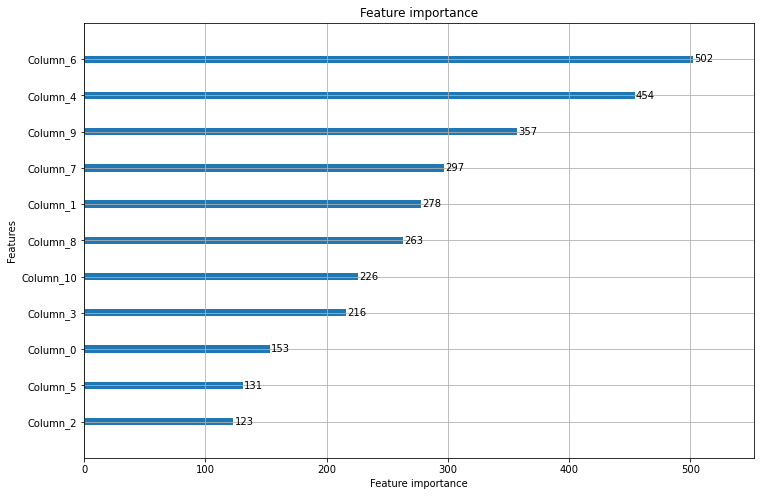

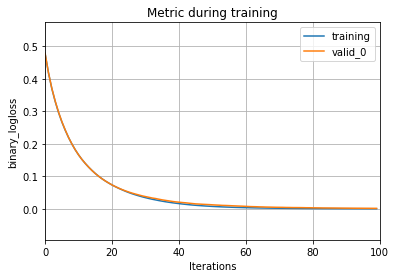

In [96]:
# Results Model LGBM Booster R/W

#import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

print(pred_wines_rw_lgbmc.shape)
print(y_test.shape)


# importances = pred_wines_rw_lgbmc.feature_importances_
# indices = np.argsort(importances)

lgb.plot_importance(lgbmc, max_num_features=40, figsize=(12,8))

# plt.barh(range(len(indices)), importances[indices], color='b', align='center')
# plt.yticks(range(len(indices)), [features[i] for i in indices])

# feature_imp = pd.DataFrame({'Value':lgbmc.feature_importance(),'Feature':X.columns})

# plt.figure(figsize=(20, 10))
# sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
# plt.title('LightGBM Features (avg over folds)')
# plt.tight_layout()
# plt.show()

#lgb.plot_tree(lgbmc,figsize=(30,40))
lgb.plot_metric(lgbmc)

print(metrics.classification_report(y_test,lgbmc.predict(X_test)))
print(confusion_matrix(y_test,pred_wines_rw_lgbmc))

print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_rw_lgbmc)))
print('Training accuracy: {:.4f}'.format(lgbmc.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(lgbmc.score(X_test,y_test)))

In [ ]:
# Model: lightgbm.Booster Label

X = wines.iloc[:, lambda df: [1, 4, 5, 10]]#[:,:-3]
var_names = X.columns
y = np.array(wines['quality_label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.quality_label)

rs=RobustScaler()

X_train = rs.fit_transform(X_train)
X_test = rs.fit_transform(X_test)


lgbmc = lgb.LGBMClassifier(learning_rate=0.09,max_depth=1000,random_state=42, n_estimators=35)
lgbmc.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)], verbose=20,eval_metric='logloss')

pred_wines_label_lgbmc= lgbmc.predict(X_test)



[20]	training's multi_logloss: 0.770419	valid_0's multi_logloss: 0.832311


C:\Users\jspad\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Counter({'medium': 2552, 'low': 2146, 'high': 1149}) Counter({'medium': 284, 'low': 238, 'high': 128})
Features: ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'alcohol']
(650,)
(650,)
              precision    recall  f1-score   support

        high       0.63      0.44      0.52       128
         low       0.67      0.70      0.69       238
      medium       0.59      0.65      0.62       284

    accuracy                           0.63       650
   macro avg       0.63      0.60      0.61       650
weighted avg       0.63      0.63      0.63       650

[[ 56  14  58]
 [  2 167  69]
 [ 31  67 186]]
Cohen-Kappa score:  0.40480713699504545
Training accuracy: 0.6937
Testing accuracy: 0.6292


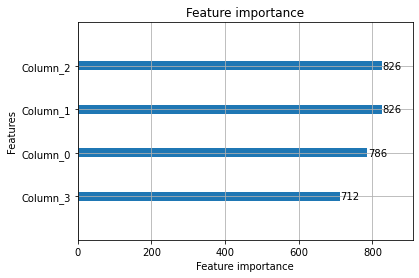

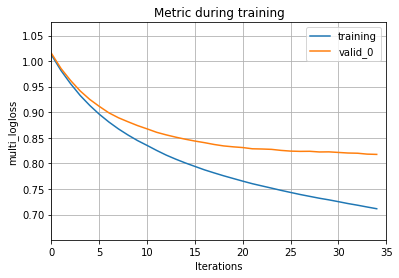

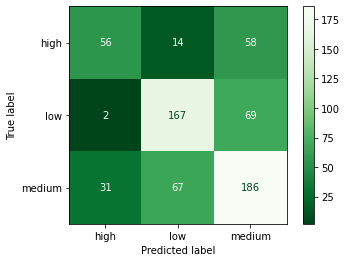

In [ ]:
#Results Model LGBM Booster Label

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

print(pred_wines_label_lgbmc.shape)
print(y_test.shape)

lgb.plot_importance(lgbmc)
lgb.plot_metric(lgbmc)
metrics.plot_confusion_matrix(lgbmc,X_test,y_test,cmap='Greens_r')
#lgb.plot_tree(lgbmc,figsize=(30,40))

print(metrics.classification_report(y_test,lgbmc.predict(X_test)))
print(confusion_matrix(y_test,pred_wines_label_lgbmc))

print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_label_lgbmc)))
print('Training accuracy: {:.4f}'.format(lgbmc.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(lgbmc.score(X_test,y_test)))

In [ ]:
# EX 3 Naive Bayes

# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.naive_bayes import GaussianNB
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix,accuracy_score
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline

X = wines.iloc[:, lambda df: [1, 4, 5, 10]]
var_names = X.columns
y = np.array(wines['quality_label'])

#X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.quality_label)


# stdsc = StandardScaler()
# X_train = stdsc.fit_transform(X_train)
# X_test = stdsc.transform(X_test)

rs=RobustScaler()
X_train = rs.fit_transform(X_train)
X_test = rs.fit_transform(X_test)

mltnb = make_pipeline(TfidfVectorizer(), MultinomialNB())

gnb = GaussianNB()
pred_wines_label_gnb = gnb.fit(X_train, y_train).predict(X_test)

print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != pred_wines_label_gnb).sum()))

cm = confusion_matrix(y_test, pred_wines_label_gnb)
ac = accuracy_score(y_test,pred_wines_label_gnb)

cm

# print(Counter(y_train), Counter(y_test))
# print('Features:', list(var_names))

# print(pred_wines_label_gnb.shape)
# print(y_test.shape)

# print(metrics.classification_report(y_test,gnb.predict(X_test)))
# print(confusion_matrix(y_test,pred_wines_label_gnb))

# print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_label_gnb)))
# print('Training accuracy: {:.4f}'.format(knn.score(X_train,y_train)))
# print('Testing accuracy: {:.4f}'.format(knn.score(X_test,y_test)))


Number of mislabeled points out of a total 3249 points : 1577


NameError: name 'svm' is not defined

In [ ]:
# NB Multinominal

# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import MinMaxScaler

X = wines.iloc[:, lambda df: [1, 4, 5, 10]]#[:,:-3]
var_names = X.columns
y = np.array(wines['quality_label'])

#X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# stdsc = StandardScaler()
# X_train = stdsc.fit_transform(X_train)
# X_test = stdsc.transform(X_test)


mms=MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

mltnb = MultinomialNB()
pred_wines_label_mltnb = mltnb.fit(X_train, y_train)

print(pred_wines_label_mltnb.predict(X[2:3]))

# sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,xticklabels=train.target_names, yticklabels=train.target_names)
# plt.xlabel('true label')
# plt.ylabel('predicted label');

#print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != pred_wines_label_mltnb).sum()))

#cm = confusion_matrix(y_test, pred_wines_label_mltnb)
#ac = accuracy_score(y_test,pred_wines_label_mltnb)

print(Counter(y_train), Counter(y_test))
print('Features:', list(var_names))

# print(pred_wines_label_mltnb.shape)
# print(y_test.shape)

print(metrics.classification_report(y_test,mltnb.predict(X_test)))
#print(confusion_matrix(y_test,pred_wines_label_mltnb))

#print("Cohen-Kappa score: ", (cohen_kappa_score(y_test,pred_wines_label_mltnb)))
print('Training accuracy: {:.4f}'.format(mltnb.score(X_train,y_train)))
print('Testing accuracy: {:.4f}'.format(mltnb.score(X_test,y_test)))

['medium']
Counter({'medium': 2556, 'low': 2128, 'high': 1163}) Counter({'medium': 280, 'low': 256, 'high': 114})
Features: ['volatile acidity', 'chlorides', 'free sulfur dioxide', 'alcohol']
              precision    recall  f1-score   support

        high       0.00      0.00      0.00       114
         low       0.79      0.09      0.15       256
      medium       0.44      0.98      0.61       280

    accuracy                           0.46       650
   macro avg       0.41      0.35      0.25       650
weighted avg       0.50      0.46      0.32       650

Training accuracy: 0.4406
Testing accuracy: 0.4554


C:\Users\jspad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jspad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jspad\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Prova viulenza

# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.datasets import make_moons, make_circles, make_classification
# from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# names = ["Nearest Neighbors","Linear SVM","RBF SVM","Gaussian Process","Decision Tree","Random Forest","Neural Net","AdaBoost","Naive Bayes","QDA",]

# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="linear", C=0.025),
#     SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
#     DecisionTreeClassifier(max_depth=5),
#     RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
#     MLPClassifier(alpha=1, max_iter=1000),
#     AdaBoostClassifier(),
#     GaussianNB(),
#     QuadraticDiscriminantAnalysis(),
# ]

# X = wines.iloc[:, lambda df: [3, 5, 7, 10]]
# var_names = X.columns
# y = np.array(wines['wine_type'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.wine_type)


# figure = plt.figure(figsize=(27, 9))
# i = 1
# # iterate over datasets
# for ds_cnt, ds in enumerate(wines):
#     # preprocess dataset, split into training and test part
#     rs=RobustScaler()
#     X_train = rs.fit_transform(X_train)
#     X_test = rs.fit_transform(X_test)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=wines.wine_type)
   

#     # x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
#     # y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
#     # xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

#     # just plot the dataset first
#     cm = plt.cm.RdBu
#     cm_bright = ListedColormap(["#FF0000", "#0000FF"])
#     ax = plt.subplot(len(wines), len(classifiers) + 1, i)
#     if ds_cnt == 0:
#         ax.set_title("Input data")
#     # Plot the training points
#     ax.scatter(X_train, X_train, c=y_train, cmap=cm_bright, edgecolors="k")
#     # Plot the testing points
#     ax.scatter(
#         X_test, X_test, c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
#     )
#     ax.set_xlim(xx.min(), xx.max())
#     ax.set_ylim(yy.min(), yy.max())
#     ax.set_xticks(())
#     ax.set_yticks(())
#     i += 1

#     # iterate over classifiers
#     for name, clf in zip(names, classifiers):
#         ax = plt.subplot(len(wines), len(classifiers) + 1, i)
#         clf.fit(X_train, y_train)
#         score = clf.score(X_test, y_test)

#         # Plot the decision boundary. For that, we will assign a color to each
#         # point in the mesh [x_min, x_max]x[y_min, y_max].
#         if hasattr(clf, "decision_function"):
#             Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
#         else:
#             Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

#         # Plot the training points
#         ax.scatter(
#             X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
#         )
#         # Plot the testing points
#         ax.scatter(
#             X_test[:, 0],
#             X_test[:, 1],
#             c=y_test,
#             cmap=cm_bright,
#             edgecolors="k",
#             alpha=0.6,
#         )

#         ax.set_xlim(xx.min(), xx.max())
#         ax.set_ylim(yy.min(), yy.max())
#         ax.set_xticks(())
#         ax.set_yticks(())
#         if ds_cnt == 0:
#             ax.set_title(name)
#         ax.text(
#             xx.max() - 0.3,
#             yy.min() + 0.3,
#             ("%.2f" % score).lstrip("0"),
#             size=15,
#             horizontalalignment="right",
#         )
#         i += 1

# plt.tight_layout()
# plt.show()

In [ ]:
#pip install lightgbm

In [ ]:
#pip install scikit-optimize

In [ ]:
#%reset